In [ ]:
!pip install pyodbc

In [ ]:
import datetime
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pyodbc

## Всем привет! Здесь описано подключение к БД, примеры запросов и тд.

### Обратите внимание на признак Probability - его использование зависит от выбранного вами направления.
### Просим в явном виде отображать его исключение в 1 направлении, мы будем каждый ноутбук проверять и прогонять модели руками (просьба не мухлевать и не использовать информацию из будущего в признаках - мы все заметим :) )

## Формат выгрузки csv-файла (столбцы):
### Для чек-поинтов - это на тренировочных данных, для финального резульата - на тестовых данных

1.   LocationId
2.   ProductId
3.   ValidationDateTime
4.   CalculatedProbability (вычисленная вами вероятность - predict_proba() )

### Также будет очень приятно, если вы нам выведите feature_importances в виде картиночки :)

In [ ]:
conn_str = """
    Driver={ODBC Driver 17 for SQL Server};
    Server=109.71.11.235;
    Database=GFC.Hackathon;
    UID=participant;
    PWD=AiNRYmEatiBL;
"""

conn = pyodbc.connect(conn_str)

In [ ]:
# пример запросов - здесь выведен весь датасет признаков
query_features = "select * from dbo.Features"
df = pd.read_sql(query_features, conn)
df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176613,2950,576631,2023-07-12 15:17:30,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176614,2950,576631,2023-07-15 15:02:34,0.497054,True,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176615,2950,576631,2023-07-26 15:01:27,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176616,2950,576631,2023-07-28 15:04:19,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [ ]:
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])

In [ ]:
# для обучения модели используем записи с IsCorrect is not null
train_query = "select * from dbo.Features f where f.IsCorrect is not null"
train_df = pd.read_sql(train_query, conn)
train_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135842,2950,574768,2023-07-19 15:01:04,0.656481,True,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135843,2950,575450,2023-06-20 15:00:06,0.778028,False,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135844,2950,576459,2023-07-02 15:01:13,0.248685,False,41.0,40.0,0.024390,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135845,2950,576631,2023-07-12 15:17:30,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [ ]:
# тестовая выборка (то, что используется в финальном зачете) - записи с IsCorrect is null
test_query = "select * from dbo.Features f where f.IsCorrect is null"
test_df = pd.read_sql(test_query, conn)
test_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288606,2023-07-25 14:57:04,0.406708,None,14.0,13.0,0.071429,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
1,63,288606,2023-08-03 14:58:53,0.460643,None,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
2,63,288783,2023-07-24 14:57:11,0.404959,None,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
3,63,288783,2023-08-03 14:57:39,0.659497,None,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
4,63,289136,2023-07-24 14:57:09,0.299769,None,6.0,6.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,2950,572875,2023-07-26 15:01:26,0.248685,None,19.0,18.0,0.052632,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40767,2950,574768,2023-07-31 15:07:00,0.173554,None,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40768,2950,576631,2023-07-26 15:01:27,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40769,2950,576631,2023-07-28 15:04:19,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0


In [ ]:
train_df.sort_values('ValidationDateTime', inplace=True)
test_df.sort_values('ValidationDateTime', inplace=True)

In [ ]:
# дополнительные таблицы с почасовыми продажами и остатками - мы ждем отвас новых интересных признаков :)
#sales_query = "select top 100 * from dbo.LocationStateHourSales"
#sales = pd.read_sql(sales_query, conn)
#sales

In [ ]:
#stocks_query = "select top 100 * from dbo.LocationStateStocks"
#stocks = pd.read_sql(stocks_query, conn)
#stocks

In [ ]:
# csv-файл для промежуточных результатов должен быть за следующие даты
#train_checkpoint = train_df.query('ValidationDateTime >= "2023-07-15"')
#train_checkpoint

# Идеи

In [ ]:

#выходной или рабочий
#праздник
#время последней продажи
#время продажи товара заменителя
#до после начала военной операции
#курс доллара на данный момент
#Покпали товар вчера
#Продажи неделю назад
#Были ли остатки вчера
#Дневная норма(сколько до нее осталось)
#Количество товаров в магазине
#Популярность товара
#Продажи за прошлу неделю
#по дням время разность первой проверки - последняя



#былили вчера остатки

#Знакомство с данными

In [ ]:
#удаляем Probability
train_df = train_df.drop(columns = "Probability")

In [ ]:
train_df.ValidationDateTime.describe()

count                         135847
unique                         53842
top              2023-07-02 14:57:19
freq                              19
first     2023-06-01 14:44:35.147000
last      2023-07-21 17:22:26.517000
Name: ValidationDateTime, dtype: object

In [ ]:
#sales_query = "select * from dbo.LocationStateHourSales"
#sales = pd.read_sql(sales_query, conn)
#sales

In [ ]:
#stocks_query = "select * from dbo.LocationStateStocks"
#stocks = pd.read_sql(stocks_query, conn)
#stocks

In [ ]:
train = train_df.query('ValidationDateTime < "2023-07-15"')
test = train_df.query('ValidationDateTime >= "2023-07-15"')

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
117948,2718,558125,2023-06-01 14:44:35.147,False,1.0,-1.0,2.000000,None,None,2.314357,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117815,2718,392473,2023-06-01 14:45:54.250,False,1.0,-1.0,2.000000,None,None,1.571429,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117813,2718,392392,2023-06-01 14:46:22.250,False,0.0,-1.0,NaN,None,None,5.535714,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117902,2718,495106,2023-06-01 14:49:22.857,False,4.0,2.0,0.500000,None,None,2.321429,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
67140,1722,425684,2023-06-01 14:49:56.067,False,1.0,0.0,1.000000,None,None,1.678571,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8216,266,394383,2023-07-14 17:27:01.180,False,4.0,2.0,0.500000,None,None,4.857143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
84914,2140,440169,2023-07-14 17:27:26.730,True,17.0,15.0,0.117647,None,None,2.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
81560,2064,563326,2023-07-14 17:27:32.187,True,1.0,1.0,0.000000,None,None,2.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
92475,2314,428334,2023-07-14 17:28:05.873,True,1.0,0.0,1.000000,None,None,1.607143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110912 entries, 117948 to 82904
Data columns (total 65 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          110912 non-null  int64         
 1   ProductId           110912 non-null  int64         
 2   ValidationDateTime  110912 non-null  datetime64[ns]
 3   IsCorrect           110912 non-null  bool          
 4   Column6             110912 non-null  float64       
 5   Column7             110912 non-null  float64       
 6   Column8             87226 non-null   float64       
 7   Column9             0 non-null       object        
 8   Column10            0 non-null       object        
 9   Column11            110912 non-null  float64       
 10  Column12            110912 non-null  int64         
 11  Column13            33066 non-null   float64       
 12  Column14            110911 non-null  float64       
 13  Column15            11087

In [ ]:
# Посмотрим на пропуски
def prop(df,return_col = False):
  df_ = df.copy()
  col_return = []
  for col in df_.columns:
    col_col = df_[col].isna().sum()
    col_proc = df_[col].isna().mean()
    if col_col > 0:
      col_return.append(col)
      print(f"{col} - {col_col} - {col_proc}%")
  if return_col:
    return col_return

In [ ]:
def col_median(df_,return_col = False):
  df = df_.copy()
  median = {}
  for col in df.columns:
    median[col] = df[col].median()         #считаем медианы
  if return_col:
    return median

def fill(df_,col_prop,col_nun):
  df = df_.copy()
  for col in col_prop:
    if col in col_nun.keys():
      df[col] = df[col].fillna(col_nun[col])    #Заполняем пропуски
      print(f"{col} - заполнена")
  return df


In [ ]:
prop_in_train = prop(train,True)

Column8 - 23686 - 0.2135566935949221%
Column9 - 110912 - 1.0%
Column10 - 110912 - 1.0%
Column13 - 77846 - 0.7018717541834968%
Column14 - 1 - 9.016156953260242e-06%
Column15 - 33 - 0.000297533179457588%
Column16 - 33 - 0.000297533179457588%
Column17 - 33 - 0.000297533179457588%
Column18 - 33 - 0.000297533179457588%
Column20 - 77769 - 0.7011775100980958%
Column21 - 22439 - 0.20231354587420658%
Column22 - 77769 - 0.7011775100980958%
Column23 - 22 - 0.00019835545297172534%
Column26 - 110912 - 1.0%
Column27 - 12 - 0.00010819388343912291%
Column28 - 55330 - 0.49886396422388923%
Column29 - 12 - 0.00010819388343912291%
Column30 - 1 - 9.016156953260242e-06%
Column31 - 1 - 9.016156953260242e-06%
Column32 - 1 - 9.016156953260242e-06%
Column33 - 1 - 9.016156953260242e-06%
Column34 - 1 - 9.016156953260242e-06%
Column35 - 1 - 9.016156953260242e-06%
Column36 - 1 - 9.016156953260242e-06%
Column37 - 1 - 9.016156953260242e-06%
Column38 - 1 - 9.016156953260242e-06%
Column39 - 668 - 0.006022792844777842%


In [ ]:
prop_in_test = prop(test,True)

Column8 - 4331 - 0.17369159815520352%
Column9 - 24935 - 1.0%
Column10 - 24935 - 1.0%
Column13 - 17435 - 0.6992179667134549%
Column15 - 1 - 4.010427110487267e-05%
Column16 - 1 - 4.010427110487267e-05%
Column17 - 1 - 4.010427110487267e-05%
Column18 - 1 - 4.010427110487267e-05%
Column20 - 18202 - 0.7299779426508923%
Column21 - 4886 - 0.19594946861840787%
Column22 - 18202 - 0.7299779426508923%
Column23 - 1 - 4.010427110487267e-05%
Column26 - 24935 - 1.0%
Column27 - 168 - 0.006737517545618609%
Column28 - 13316 - 0.5340284740324844%
Column29 - 168 - 0.006737517545618609%
Column39 - 129 - 0.005173450972528575%
Column40 - 129 - 0.005173450972528575%
Column41 - 129 - 0.005173450972528575%
Column43 - 129 - 0.005173450972528575%
Column44 - 129 - 0.005173450972528575%
Column46 - 129 - 0.005173450972528575%
Column50 - 129 - 0.005173450972528575%
Column51 - 129 - 0.005173450972528575%
Column66 - 24935 - 1.0%


In [ ]:
prop_in_test_df = prop(test_df,True)

Probability - 133 - 0.003262122587133011%
IsCorrect - 40771 - 1.0%
Column8 - 7115 - 0.17451129479286748%
Column9 - 40771 - 1.0%
Column10 - 40771 - 1.0%
Column13 - 35474 - 0.870079222977116%
Column15 - 1 - 2.4527237497240686e-05%
Column16 - 1 - 2.4527237497240686e-05%
Column17 - 1 - 2.4527237497240686e-05%
Column18 - 1 - 2.4527237497240686e-05%
Column20 - 25359 - 0.6219862156925265%
Column21 - 6538 - 0.1603590787569596%
Column22 - 25359 - 0.6219862156925265%
Column26 - 40771 - 1.0%
Column27 - 133 - 0.003262122587133011%
Column28 - 18676 - 0.458070687498467%
Column29 - 133 - 0.003262122587133011%
Column39 - 322 - 0.0078977704741115%
Column40 - 322 - 0.0078977704741115%
Column41 - 322 - 0.0078977704741115%
Column43 - 322 - 0.0078977704741115%
Column44 - 322 - 0.0078977704741115%
Column46 - 322 - 0.0078977704741115%
Column50 - 322 - 0.0078977704741115%
Column51 - 322 - 0.0078977704741115%
Column66 - 40771 - 1.0%


In [ ]:
columns_for_drop = ["Column9","Column10","Column26","Column66"]

In [ ]:
train = train.drop(columns = columns_for_drop)
test = test.drop(columns = columns_for_drop)
test_df = test_df.drop(columns = columns_for_drop)

In [ ]:
prop_in_train = prop(train,True)
prop_in_test = prop(test,True)
prop_in_test_df = prop(test_df,True)

Column8 - 23686 - 0.2135566935949221%
Column13 - 77846 - 0.7018717541834968%
Column14 - 1 - 9.016156953260242e-06%
Column15 - 33 - 0.000297533179457588%
Column16 - 33 - 0.000297533179457588%
Column17 - 33 - 0.000297533179457588%
Column18 - 33 - 0.000297533179457588%
Column20 - 77769 - 0.7011775100980958%
Column21 - 22439 - 0.20231354587420658%
Column22 - 77769 - 0.7011775100980958%
Column23 - 22 - 0.00019835545297172534%
Column27 - 12 - 0.00010819388343912291%
Column28 - 55330 - 0.49886396422388923%
Column29 - 12 - 0.00010819388343912291%
Column30 - 1 - 9.016156953260242e-06%
Column31 - 1 - 9.016156953260242e-06%
Column32 - 1 - 9.016156953260242e-06%
Column33 - 1 - 9.016156953260242e-06%
Column34 - 1 - 9.016156953260242e-06%
Column35 - 1 - 9.016156953260242e-06%
Column36 - 1 - 9.016156953260242e-06%
Column37 - 1 - 9.016156953260242e-06%
Column38 - 1 - 9.016156953260242e-06%
Column39 - 668 - 0.006022792844777842%
Column40 - 668 - 0.006022792844777842%
Column41 - 668 - 0.0060227928447778

In [ ]:
train.describe()

,LocationId,ProductId,Column6,Column7,Column8,Column11,Column12,Column13,Column14,Column15,...,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67
count,110912.000000,110912.000000,110912.000000,110912.000000,87226.000000,110912.000000,110912.000000,33066.000000,110911.000000,110879.000000,...,110911.000000,110911.0,110911.0,110911.0,110911.0,110911.0,110911.0,110911.0,110911.0,110911.0
mean,1665.464341,421423.112558,4.857040,3.952413,0.353439,4.399742,20.539572,4.484424,61.440385,61.219310,...,61.440385,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
std,891.074678,79927.065613,8.135927,8.137644,0.378563,4.677657,6.043953,6.213773,48.730418,48.148050,...,48.730418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,63.000000,288525.000000,0.000000,-2.000000,0.000000,0.035714,0.000000,0.000000,0.200000,0.200000,...,0.200000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,873.000000,356920.000000,1.000000,0.000000,0.083333,2.214286,17.000000,2.000000,27.990000,27.958333,...,27.990000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50%,1736.000000,425847.000000,3.000000,2.000000,0.250000,3.500000,22.000000,3.166667,51.101112,50.990002,...,51.101112,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75%,2559.000000,485259.000000,6.000000,5.000000,0.500000,5.285714,26.000000,5.071429,77.989998,76.990005,...,77.989998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
max,2950.000000,576661.000000,89.000000,89.000000,2.000000,386.107147,28.000000,386.190491,1650.000000,599.900879,...,1650.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110912 entries, 117948 to 82904
Data columns (total 61 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          110912 non-null  int64         
 1   ProductId           110912 non-null  int64         
 2   ValidationDateTime  110912 non-null  datetime64[ns]
 3   IsCorrect           110912 non-null  bool          
 4   Column6             110912 non-null  float64       
 5   Column7             110912 non-null  float64       
 6   Column8             87226 non-null   float64       
 7   Column11            110912 non-null  float64       
 8   Column12            110912 non-null  int64         
 9   Column13            33066 non-null   float64       
 10  Column14            110911 non-null  float64       
 11  Column15            110879 non-null  float64       
 12  Column16            110879 non-null  float64       
 13  Column17            11087

In [ ]:
object_col = train.loc[:,train.dtypes == object].columns
bool_col = train.loc[:,train.dtypes == bool].columns
numeric_col = [col for col in train.columns if col not in object_col and col not in bool_col]

In [ ]:
len(object_col) + len(bool_col) + len(numeric_col) == train.shape[1]

True

In [ ]:
train[object_col]

,Column45,Column46,Column47
117948,False,False,False
117815,False,False,False
117813,False,False,False
117902,True,False,True
67140,False,False,False
...,...,...,...
8216,False,False,False
84914,False,False,False
81560,False,True,True
92475,True,False,True


In [ ]:
train[bool_col]

,IsCorrect,Column19
117948,False,False
117815,False,False
117813,False,False
117902,False,True
67140,False,False
...,...,...
8216,False,False
84914,True,False
81560,True,False
92475,True,True


In [ ]:
bool_col.tolist() + object_col.tolist()

['IsCorrect', 'Column19', 'Column45', 'Column46', 'Column47']

In [ ]:
def as_int(x):
  if x == True or x == "True":
    return 1
  elif x == False or x == "False":
    return 0


In [ ]:
train.IsCorrect.value_counts()

False    92677
True     18235
Name: IsCorrect, dtype: int64

In [ ]:
for col in bool_col.tolist() + object_col.tolist():
  train[col] = train[col].apply(lambda x: as_int(x))
  test[col] = test[col].apply(lambda x: as_int(x))
  if col != "IsCorrect":
    test_df[col] = test_df[col].apply(lambda x: as_int(x))

In [ ]:
train.IsCorrect.value_counts()

0    92677
1    18235
Name: IsCorrect, dtype: int64

In [ ]:
numeric_col += bool_col.tolist() + object_col.tolist()

In [ ]:
len(numeric_col) == train.shape[1]

True

In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110912 entries, 117948 to 82904
Data columns (total 61 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          110912 non-null  int64         
 1   ProductId           110912 non-null  int64         
 2   ValidationDateTime  110912 non-null  datetime64[ns]
 3   IsCorrect           110912 non-null  int64         
 4   Column6             110912 non-null  float64       
 5   Column7             110912 non-null  float64       
 6   Column8             87226 non-null   float64       
 7   Column11            110912 non-null  float64       
 8   Column12            110912 non-null  int64         
 9   Column13            33066 non-null   float64       
 10  Column14            110911 non-null  float64       
 11  Column15            110879 non-null  float64       
 12  Column16            110879 non-null  float64       
 13  Column17            11087

In [ ]:
fill_nun = col_median(train,True)
train = fill(train,prop_in_train,fill_nun)
test = fill(test,prop_in_test,fill_nun)
test_df = fill(test_df,prop_in_test_df,fill_nun)

Column8 - заполнена
Column13 - заполнена
Column14 - заполнена
Column15 - заполнена
Column16 - заполнена
Column17 - заполнена
Column18 - заполнена
Column20 - заполнена
Column21 - заполнена
Column22 - заполнена
Column23 - заполнена
Column27 - заполнена
Column28 - заполнена
Column29 - заполнена
Column30 - заполнена
Column31 - заполнена
Column32 - заполнена
Column33 - заполнена
Column34 - заполнена
Column35 - заполнена
Column36 - заполнена
Column37 - заполнена
Column38 - заполнена
Column39 - заполнена
Column40 - заполнена
Column41 - заполнена
Column42 - заполнена
Column43 - заполнена
Column44 - заполнена
Column45 - заполнена
Column46 - заполнена
Column47 - заполнена
Column49 - заполнена
Column50 - заполнена
Column51 - заполнена
Column52 - заполнена
Column53 - заполнена
Column54 - заполнена
Column55 - заполнена
Column56 - заполнена
Column57 - заполнена
Column58 - заполнена
Column59 - заполнена
Column60 - заполнена
Column61 - заполнена
Column62 - заполнена
Column63 - заполнена
Column64 - зап

In [ ]:
remote_col = []

In [ ]:
remote_col += columns_for_drop
columns_for_drop = []


In [ ]:
def threshold(df_,threshold=1,return_col = False):
  df = df_.copy()
  for_drop = {}
  for col in df.columns:
    std = round(df[col].std(),3)
    if std < threshold:
      for_drop[col] = std
    print(f"{col} -- std = {std} ")
  if return_col:
    return for_drop

In [ ]:
columns_for_work = train.drop(columns = ["ValidationDateTime","IsCorrect"]).columns

In [ ]:
columns_for_drop = threshold(train[columns_for_work],0.1,True)

LocationId -- std = 891.075 
ProductId -- std = 79927.066 
Column6 -- std = 8.136 
Column7 -- std = 8.138 
Column8 -- std = 0.338 
Column11 -- std = 4.678 
Column12 -- std = 6.044 
Column13 -- std = 3.446 
Column14 -- std = 48.73 
Column15 -- std = 48.141 
Column16 -- std = 7.253 
Column17 -- std = 0.203 
Column18 -- std = 1.457 
Column19 -- std = 0.5 
Column20 -- std = 5.902 
Column21 -- std = 7.671 
Column22 -- std = 0.014 
Column23 -- std = 75.016 
Column24 -- std = 5.157 
Column25 -- std = 8.443 
Column27 -- std = 2.96 
Column28 -- std = 0.75 
Column29 -- std = 0.2 
Column30 -- std = 49.251 
Column31 -- std = 47.605 
Column32 -- std = 61.309 
Column33 -- std = 43.353 
Column34 -- std = 0.157 
Column35 -- std = 0.324 
Column36 -- std = 118063.393 
Column37 -- std = 6866160.337 
Column38 -- std = 48.73 
Column39 -- std = 52.745 
Column40 -- std = 17.644 
Column41 -- std = 1.126 
Column42 -- std = 0.135 
Column43 -- std = 0.123 
Column44 -- std = 0.136 
Column45 -- std = 0.5 
Column46

In [ ]:
len(columns_for_drop)

10

In [ ]:
train[[col for col in columns_for_drop.keys() if columns_for_drop[col] != 0]].describe()

,Column22
count,110912.000000
mean,0.999109
std,0.013630
min,0.500000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
train.Column22.value_counts()

1.000000    110237
0.800000        71
0.750000        58
0.909091        56
0.857143        55
0.666667        54
0.833333        44
0.916667        40
0.900000        34
0.875000        31
0.928571        28
0.947368        27
0.888889        26
0.933333        26
0.944444        25
0.923077        24
0.937500        24
0.941176        19
0.500000        13
0.950000         9
0.962963         2
0.967742         2
0.958333         1
0.956522         1
0.973684         1
0.971429         1
0.965517         1
0.970588         1
0.961538         1
Name: Column22, dtype: int64

In [ ]:
columns_for_drop = [col for col in columns_for_drop.keys() if columns_for_drop[col] == 0]

In [ ]:
train = train.drop(columns = columns_for_drop)
test = test.drop(columns = columns_for_drop)
test_df = test_df.drop(columns = columns_for_drop)

In [ ]:
remote_col += columns_for_drop
columns_for_drop = []

In [ ]:
remote_col

['Column9',
 'Column10',
 'Column26',
 'Column66',
 'Column58',
 'Column59',
 'Column60',
 'Column61',
 'Column62',
 'Column63',
 'Column64',
 'Column65',
 'Column67']

In [ ]:
columns_for_work = train.drop(columns = ["ValidationDateTime","IsCorrect"]).columns

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57
117948,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,0.0,0.0,0.0,0.0,1.0,121.899796,121.899796,121.899796,121.899796,121.899796
117815,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,0.0,0.0,0.0,0.0,1.0,29.992500,29.992500,29.992500,29.992500,29.992500
117813,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,0.0,0.0,0.0,0.0,1.0,36.490002,36.490002,36.490002,36.490002,36.490002
117902,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,1.0,1.0,0.0,1.0,0.0,137.461655,137.461655,137.461655,137.461655,137.461655
67140,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,0.0,0.0,0.0,0.0,1.0,39.990002,39.990002,39.990002,39.990002,39.990002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8216,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,0.0,0.0,0.0,0.0,1.0,20.990000,20.990000,20.990000,20.990000,20.990000
84914,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,0.0,0.0,0.0,0.0,1.0,72.989998,72.989998,72.989998,72.989998,72.989998
81560,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,1.0,0.0,1.0,-1.0,0.0,59.742500,59.742500,59.742500,59.742500,59.742500
92475,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,1.0,1.0,0.0,1.0,0.0,149.899994,149.899994,149.899994,149.899994,149.899994


## Сохранение данных


In [ ]:
train.to_csv("train.csv",index = False)

In [ ]:
test.to_csv("test.csv",index = False)

## Графики

In [ ]:
#Базовые настройки matplotlib
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

mlp.rcParams['lines.linewidth'] = 5
mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

In [ ]:
#sns.pairplot(train)

## Предобработка данных

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57
117948,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,0.0,0.0,0.0,0.0,1.0,121.899796,121.899796,121.899796,121.899796,121.899796
117815,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,0.0,0.0,0.0,0.0,1.0,29.992500,29.992500,29.992500,29.992500,29.992500
117813,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,0.0,0.0,0.0,0.0,1.0,36.490002,36.490002,36.490002,36.490002,36.490002
117902,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,1.0,1.0,0.0,1.0,0.0,137.461655,137.461655,137.461655,137.461655,137.461655
67140,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,0.0,0.0,0.0,0.0,1.0,39.990002,39.990002,39.990002,39.990002,39.990002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8216,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,0.0,0.0,0.0,0.0,1.0,20.990000,20.990000,20.990000,20.990000,20.990000
84914,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,0.0,0.0,0.0,0.0,1.0,72.989998,72.989998,72.989998,72.989998,72.989998
81560,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,1.0,0.0,1.0,-1.0,0.0,59.742500,59.742500,59.742500,59.742500,59.742500
92475,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,1.0,1.0,0.0,1.0,0.0,149.899994,149.899994,149.899994,149.899994,149.899994


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
columns_for_work = train.drop(columns = ["ValidationDateTime","IsCorrect","LocationId","ProductId"]).columns

In [ ]:
scaler.fit(train[columns_for_work])

StandardScaler()

In [ ]:
scaler_test = test.copy()
scaler_train = train.copy()


In [ ]:
scaler_train[columns_for_work] = scaler.transform(train[columns_for_work])
scaler_test[columns_for_work] = scaler.transform(test[columns_for_work])

In [ ]:
scaler_train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57
117948,2718,558125,2023-06-01 14:44:35.147,0,-0.474077,-0.608583,4.931293,-0.445820,-1.909284,0.285793,...,-0.804224,-0.998144,-0.762515,-0.206562,0.814415,1.240704,1.240704,1.240704,1.240704,1.240704
117815,2718,392473,2023-06-01 14:45:54.250,0,-0.474077,-0.608583,4.931293,-0.604646,-1.578374,-0.162376,...,-0.804224,-0.998144,-0.762515,-0.206562,0.814415,-0.645348,-0.645348,-0.645348,-0.645348,-0.645348
117813,2718,392392,2023-06-01 14:46:22.250,0,-0.596989,-0.608583,-0.240406,0.242852,-0.420186,0.824312,...,-0.804224,-0.998144,-0.762515,-0.206562,0.814415,-0.512011,-0.512011,-0.512011,-0.512011,-0.512011
117902,2718,495106,2023-06-01 14:49:22.857,0,-0.105341,-0.239925,0.498408,-0.444308,-2.240195,-0.452578,...,1.243435,1.001859,-0.762515,1.422784,-1.227875,1.560053,1.560053,1.560053,1.560053,1.560053
67140,1722,425684,2023-06-01 14:49:56.067,0,-0.474077,-0.485697,1.976037,-0.581740,-0.916552,-0.239763,...,-0.804224,-0.998144,-0.762515,-0.206562,0.814415,-0.440187,-0.440187,-0.440187,-0.440187,-0.440187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8216,266,394383,2023-07-14 17:27:01.180,0,-0.105341,-0.239925,0.498408,0.097785,0.407091,0.907745,...,-0.804224,-0.998144,-0.762515,-0.206562,0.814415,-0.830090,-0.830090,-0.830090,-0.830090,-0.830090
84914,2140,440169,2023-07-14 17:27:26.730,1,1.492518,1.357597,-0.631543,-0.513024,-0.585641,-0.278457,...,-0.804224,-0.998144,-0.762515,-0.206562,0.814415,0.237014,0.237014,0.237014,0.237014,0.237014
81560,2064,563326,2023-07-14 17:27:32.187,1,-0.474077,-0.362811,-0.979220,-0.513024,0.738002,-0.162376,...,1.243435,-0.998144,1.311449,-1.835908,-1.227875,-0.034841,-0.034841,-0.034841,-0.034841,-0.034841
92475,2314,428334,2023-07-14 17:28:05.873,1,-0.474077,-0.485697,1.976037,-0.597011,-0.916552,-0.286749,...,1.243435,1.001859,-0.762515,1.422784,-1.227875,1.815303,1.815303,1.815303,1.815303,1.815303


In [ ]:
X = scaler_train.drop(columns = ["IsCorrect"])
y = scaler_train.IsCorrect

X_test = scaler_test.drop(columns = ["IsCorrect"])
y_test = scaler_test.IsCorrect

# Моделирование(Pipeline)


In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

catboost = CatBoostClassifier()

catboost.fit(X, y)

Learning rate set to 0.076938
0:	learn: 0.6346964	total: 13.2ms	remaining: 13.2s
1:	learn: 0.5905343	total: 24.5ms	remaining: 12.2s
2:	learn: 0.5512565	total: 35.3ms	remaining: 11.7s
3:	learn: 0.5187957	total: 46.3ms	remaining: 11.5s
4:	learn: 0.4926680	total: 58ms	remaining: 11.6s
5:	learn: 0.4705815	total: 71.6ms	remaining: 11.9s
6:	learn: 0.4521627	total: 85.3ms	remaining: 12.1s
7:	learn: 0.4384517	total: 97.7ms	remaining: 12.1s
8:	learn: 0.4255735	total: 109ms	remaining: 12s
9:	learn: 0.4144678	total: 121ms	remaining: 12s
10:	learn: 0.4069337	total: 135ms	remaining: 12.1s
11:	learn: 0.4006306	total: 147ms	remaining: 12.1s
12:	learn: 0.3940154	total: 159ms	remaining: 12.1s
13:	learn: 0.3884734	total: 170ms	remaining: 12s
14:	learn: 0.3841345	total: 181ms	remaining: 11.9s
15:	learn: 0.3803160	total: 193ms	remaining: 11.9s
16:	learn: 0.3771863	total: 205ms	remaining: 11.8s
17:	learn: 0.3745372	total: 217ms	remaining: 11.8s
18:	learn: 0.3719540	total: 229ms	remaining: 11.8s
19:	learn: 

In [ ]:
scaler_test["answer"] = catboost.predict(X_test)

In [ ]:
scaler_test["answer"] = scaler_test["answer"].astype(bool)


In [ ]:
scaler_test["CalculatedProbability"] = catboost.predict_proba(X_test)[:,1]

In [ ]:
np.mean(scaler_test["IsCorrect"] == scaler_test["answer"])

0.7178664527772207

In [ ]:
scaler_test[["LocationId","ProductId","ValidationDateTime","CalculatedProbability"]].to_csv("Команда2_Направление1.csv",sep = ";")

In [ ]:
scaler_test[["LocationId","ProductId","ValidationDateTime","CalculatedProbability"]]

,LocationId,ProductId,ValidationDateTime,CalculatedProbability
107777,2648,401972,2023-07-15 14:54:39.167,0.171650
107773,2648,401971,2023-07-15 14:55:00.033,0.222875
661,63,510528,2023-07-15 14:58:10.000,0.950624
66920,1719,523365,2023-07-15 14:58:10.000,0.818484
66605,1719,355836,2023-07-15 14:58:10.000,0.803184
...,...,...,...,...
81151,2056,489873,2023-07-21 16:46:15.510,0.284131
80402,2022,440169,2023-07-21 16:48:18.217,0.789306
68471,1788,426699,2023-07-21 16:48:32.930,0.480407
68475,1788,427524,2023-07-21 16:50:45.543,0.238901


Считаем ROC-AUC

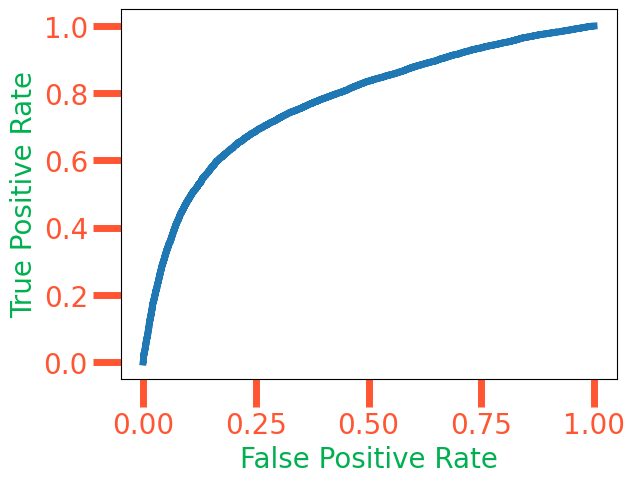

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.7759703326462669

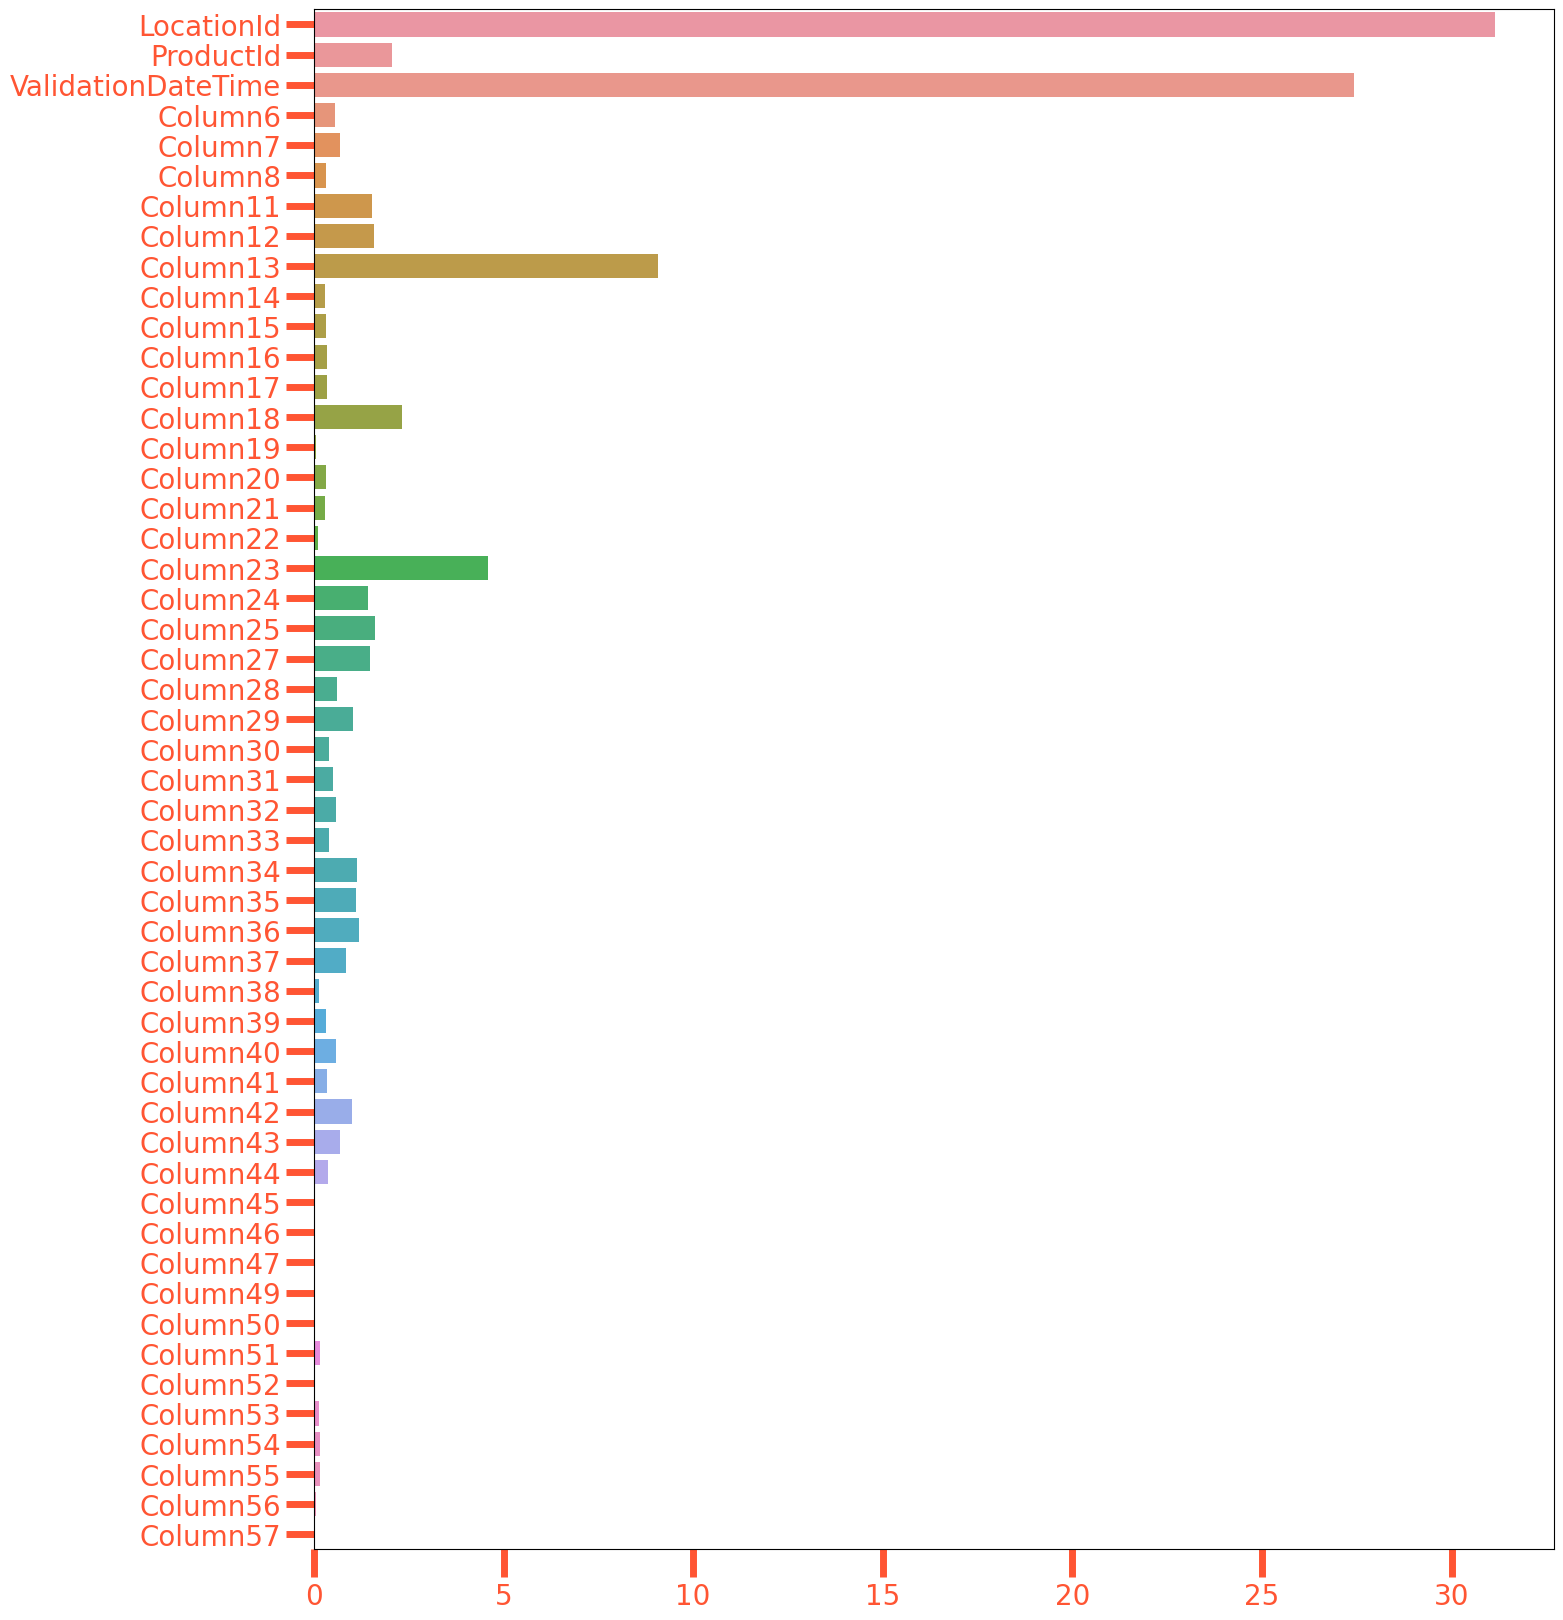

In [ ]:
fig = plt.figure()
fig.set_size_inches(16, 20)

sns.barplot(x= catboost.feature_importances_,
            y= catboost.feature_names_)


plt.show()

In [ ]:
may_be_drop = ["Column57","Column45","Column46","Column47","Column49","Column50","Column52"]

Просто проверим что будет удалив "лишние" колонки




In [ ]:
X = X.drop(columns = may_be_drop)
X_test = X_test.drop(columns = may_be_drop)

In [ ]:
catboost = CatBoostClassifier()

catboost.fit(X, y)

Learning rate set to 0.076938
0:	learn: 0.6348515	total: 13.2ms	remaining: 13.2s
1:	learn: 0.5906234	total: 24.4ms	remaining: 12.2s
2:	learn: 0.5504921	total: 35.9ms	remaining: 11.9s
3:	learn: 0.5173196	total: 46.8ms	remaining: 11.7s
4:	learn: 0.4918723	total: 58.5ms	remaining: 11.6s
5:	learn: 0.4726159	total: 70.6ms	remaining: 11.7s
6:	learn: 0.4537725	total: 82.1ms	remaining: 11.6s
7:	learn: 0.4397320	total: 94ms	remaining: 11.7s
8:	learn: 0.4280369	total: 105ms	remaining: 11.6s
9:	learn: 0.4166376	total: 118ms	remaining: 11.7s
10:	learn: 0.4084633	total: 129ms	remaining: 11.6s
11:	learn: 0.4006294	total: 142ms	remaining: 11.7s
12:	learn: 0.3942502	total: 152ms	remaining: 11.6s
13:	learn: 0.3894503	total: 165ms	remaining: 11.6s
14:	learn: 0.3849793	total: 176ms	remaining: 11.5s
15:	learn: 0.3809898	total: 189ms	remaining: 11.6s
16:	learn: 0.3777918	total: 202ms	remaining: 11.7s
17:	learn: 0.3745209	total: 215ms	remaining: 11.7s
18:	learn: 0.3726768	total: 226ms	remaining: 11.7s
19:	l

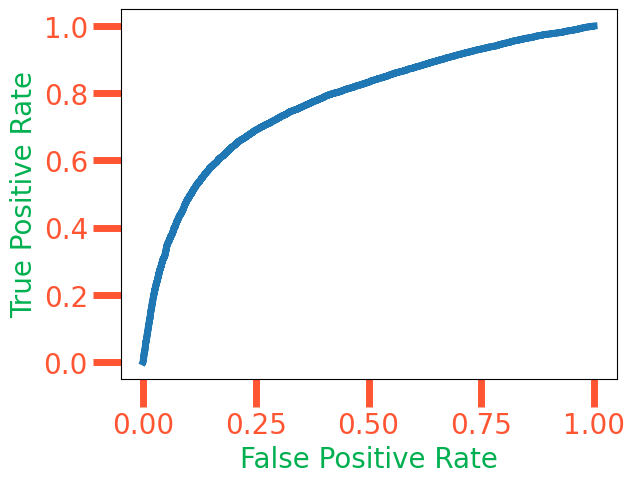

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
from sklearn.metrics import auc

auc(fpr, tpr) # небольшой прирост

0.7765009545692068

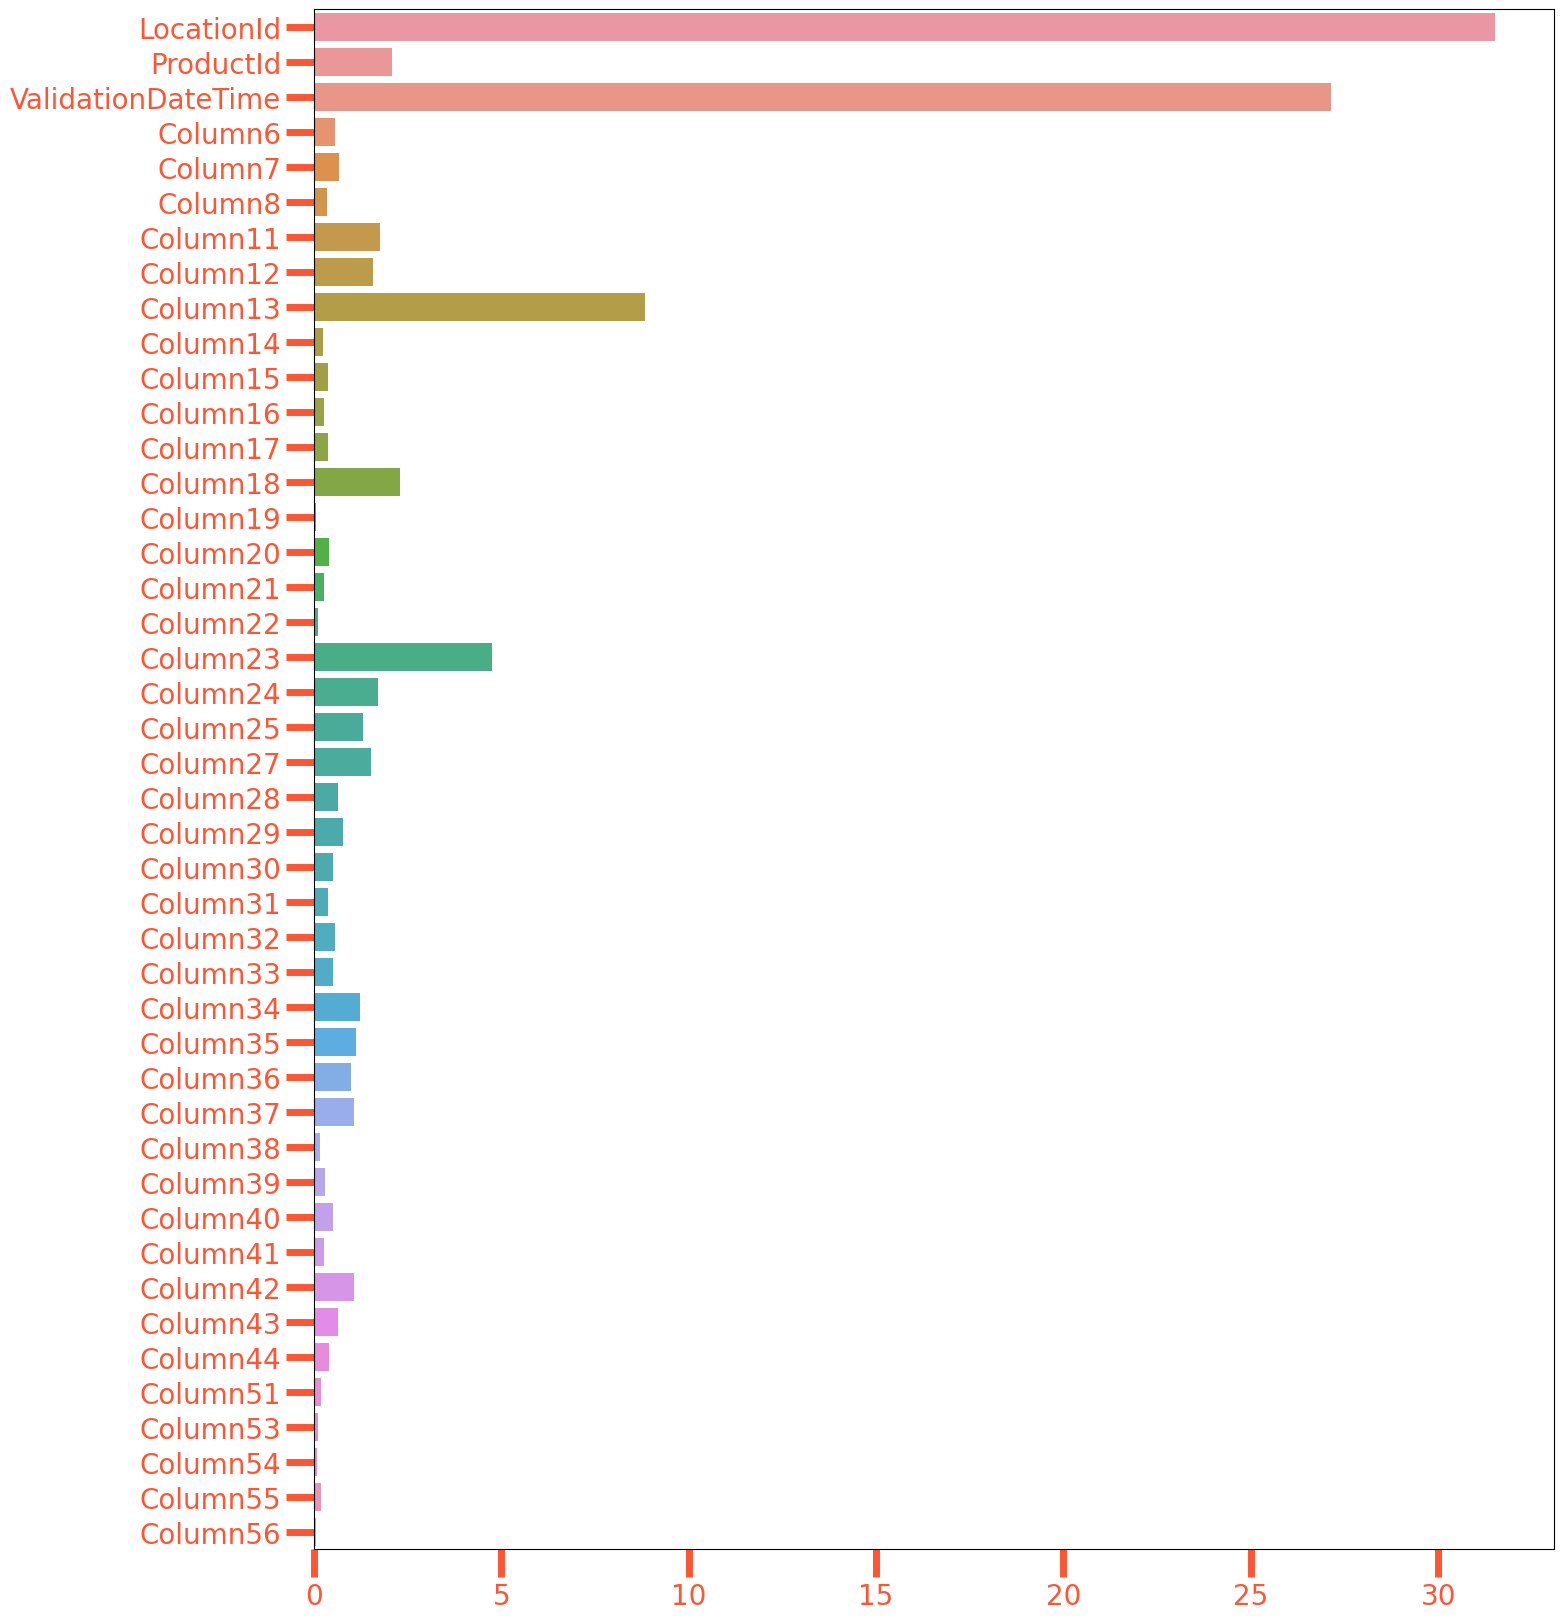

In [ ]:
fig = plt.figure()
fig.set_size_inches(16, 20)

sns.barplot(x= catboost.feature_importances_,
            y= catboost.feature_names_)


plt.show()

# Генирация новых фичей

In [ ]:
train.ValidationDateTime.describe()

count                         110912
unique                         44582
top              2023-07-02 15:00:50
freq                              19
first     2023-06-01 14:44:35.147000
last      2023-07-14 17:29:33.350000
Name: ValidationDateTime, dtype: object

In [ ]:
train["mounth"] = train.ValidationDateTime.dt.month
train["week"] = train.ValidationDateTime.dt.week
train["day"] = train.ValidationDateTime.dt.day
train["week_day"] = train.ValidationDateTime.dt.weekday

In [ ]:
train["hour"] = train.ValidationDateTime.dt.hour
train["minute"] = train.ValidationDateTime.dt.minute

In [ ]:
test["mounth"] = test.ValidationDateTime.dt.month
test["week"] = test.ValidationDateTime.dt.week
test["day"] = test.ValidationDateTime.dt.day
test["week_day"] = test.ValidationDateTime.dt.weekday
test["hour"] = test.ValidationDateTime.dt.hour
test["minute"] = test.ValidationDateTime.dt.minute

In [ ]:
test_df["mounth"] = test_df.ValidationDateTime.dt.month
test_df["week"] = test_df.ValidationDateTime.dt.week
test_df["day"] = test_df.ValidationDateTime.dt.day
test_df["week_day"] = test_df.ValidationDateTime.dt.weekday
test_df["hour"] = test_df.ValidationDateTime.dt.hour
test_df["minute"] = test_df.ValidationDateTime.dt.minute

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,Column54,Column55,Column56,Column57,mounth,week,day,week_day,hour,minute
117948,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,121.899796,121.899796,121.899796,121.899796,6,22,1,3,14,44
117815,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,29.992500,29.992500,29.992500,29.992500,6,22,1,3,14,45
117813,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,36.490002,36.490002,36.490002,36.490002,6,22,1,3,14,46
117902,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,137.461655,137.461655,137.461655,137.461655,6,22,1,3,14,49
67140,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,39.990002,39.990002,39.990002,39.990002,6,22,1,3,14,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8216,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,20.990000,20.990000,20.990000,20.990000,7,28,14,4,17,27
84914,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,72.989998,72.989998,72.989998,72.989998,7,28,14,4,17,27
81560,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,59.742500,59.742500,59.742500,59.742500,7,28,14,4,17,27
92475,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,149.899994,149.899994,149.899994,149.899994,7,28,14,4,17,28


In [ ]:
def weekend(x):
  if x == 5 or x == 6:
    return 1
  else:
    return 0

In [ ]:
train["weekend"] = train["week_day"].apply(lambda x: weekend(x))

In [ ]:
test["weekend"] = test["week_day"].apply(lambda x: weekend(x))

In [ ]:
test_df["weekend"] = test_df["week_day"].apply(lambda x: weekend(x))

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,Column55,Column56,Column57,mounth,week,day,week_day,hour,minute,weekend
117948,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,121.899796,121.899796,121.899796,6,22,1,3,14,44,0
117815,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,29.992500,29.992500,29.992500,6,22,1,3,14,45,0
117813,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,36.490002,36.490002,36.490002,6,22,1,3,14,46,0
117902,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,137.461655,137.461655,137.461655,6,22,1,3,14,49,0
67140,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,39.990002,39.990002,39.990002,6,22,1,3,14,49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8216,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,20.990000,20.990000,20.990000,7,28,14,4,17,27,0
84914,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,72.989998,72.989998,72.989998,7,28,14,4,17,27,0
81560,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,59.742500,59.742500,59.742500,7,28,14,4,17,27,0
92475,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,149.899994,149.899994,149.899994,7,28,14,4,17,28,0


In [ ]:
df_first_info = train.groupby(["LocationId","ProductId"]).min()["ValidationDateTime"].reset_index().rename(columns = {"ValidationDateTime" : "date_first_info"})

In [ ]:
train = train.merge(df_first_info,how = "left",on = ["LocationId","ProductId"])

In [ ]:
test = test.merge(df_first_info,how = "left",on = ["LocationId","ProductId"])

In [ ]:
test_df = test_df.merge(df_first_info,how = "left",on = ["LocationId","ProductId"])

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,Column56,Column57,mounth,week,day,week_day,hour,minute,weekend,date_first_info
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,121.899796,121.899796,6,22,1,3,14,44,0,2023-06-01 14:44:35.147
1,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,29.992500,29.992500,6,22,1,3,14,45,0,2023-06-01 14:45:54.250
2,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,36.490002,36.490002,6,22,1,3,14,46,0,2023-06-01 14:46:22.250
3,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,137.461655,137.461655,6,22,1,3,14,49,0,2023-06-01 14:49:22.857
4,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,39.990002,39.990002,6,22,1,3,14,49,0,2023-06-01 14:49:56.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110907,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,20.990000,20.990000,7,28,14,4,17,27,0,2023-06-20 16:51:49.277
110908,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,72.989998,72.989998,7,28,14,4,17,27,0,2023-06-09 15:57:02.337
110909,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,59.742500,59.742500,7,28,14,4,17,27,0,2023-07-14 17:27:32.187
110910,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,149.899994,149.899994,7,28,14,4,17,28,0,2023-07-14 17:28:05.873


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110912 entries, 0 to 110911
Data columns (total 60 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          110912 non-null  int64         
 1   ProductId           110912 non-null  int64         
 2   ValidationDateTime  110912 non-null  datetime64[ns]
 3   IsCorrect           110912 non-null  int64         
 4   Column6             110912 non-null  float64       
 5   Column7             110912 non-null  float64       
 6   Column8             110912 non-null  float64       
 7   Column11            110912 non-null  float64       
 8   Column12            110912 non-null  int64         
 9   Column13            110912 non-null  float64       
 10  Column14            110912 non-null  float64       
 11  Column15            110912 non-null  float64       
 12  Column16            110912 non-null  float64       
 13  Column17            110912 no

In [ ]:
train["spros"] = (train.ValidationDateTime - train.date_first_info).dt.days

In [ ]:
test["spros"] = (test.ValidationDateTime - test.date_first_info).dt.days

In [ ]:
test_df["spros"] = (test_df.ValidationDateTime - test_df.date_first_info).dt.days

In [ ]:
train.spros.describe()

count    110912.000000
mean          7.724088
std          10.591256
min           0.000000
25%           0.000000
50%           2.000000
75%          13.000000
max          43.000000
Name: spros, dtype: float64

In [ ]:
print(train.spros.value_counts())

0     52639
2      3415
3      3189
4      2729
5      2684
7      2592
6      2576
8      2259
1      2138
9      2128
10     1915
12     1896
11     1838
14     1795
13     1748
15     1568
17     1474
16     1465
20     1354
19     1328
18     1299
21     1216
28     1208
24     1142
23     1120
26     1109
22     1104
27     1002
25      993
29      993
31      940
30      858
32      806
35      744
33      740
34      640
37      571
36      530
38      456
40      259
39      209
41      167
42       66
43       10
Name: spros, dtype: int64


In [ ]:
#выходной или рабочий +
#праздник +
#время последней продажи ?
#время продажи товара заменителя ?
#до после начала военной операции -
#курс доллара на данный момент +
#Покпали товар вчера
#Продажи неделю назад
#Были ли остатки вчера
#Дневная норма(сколько до нее осталось)
#Количество товаров в магазине
#Популярность товара
#Продажи за прошлу неделю
#по дням время разность первой проверки - последняя



#былили вчера остатки

In [ ]:
goods_in_shop = train.groupby(['LocationId']).nunique()["ProductId"].reset_index().rename(columns = {"ProductId" : "num_of_g"})

In [ ]:
train = train.merge(goods_in_shop,how = "left",on = "LocationId")

In [ ]:
test = test.merge(goods_in_shop,how = "left",on = "LocationId")

In [ ]:
test_df = test_df.merge(goods_in_shop,how = "left",on = "LocationId")

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,mounth,week,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,6,22,1,3,14,44,0,2023-06-01 14:44:35.147,0,141
1,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,6,22,1,3,14,45,0,2023-06-01 14:45:54.250,0,141
2,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,6,22,1,3,14,46,0,2023-06-01 14:46:22.250,0,141
3,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,6,22,1,3,14,49,0,2023-06-01 14:49:22.857,0,141
4,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,6,22,1,3,14,49,0,2023-06-01 14:49:56.067,0,160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110907,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,7,28,14,4,17,27,0,2023-06-20 16:51:49.277,24,108
110908,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,7,28,14,4,17,27,0,2023-06-09 15:57:02.337,35,45
110909,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,7,28,14,4,17,27,0,2023-07-14 17:27:32.187,0,1
110910,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,7,28,14,4,17,28,0,2023-07-14 17:28:05.873,0,23


In [ ]:
how_unic_goods = train.groupby(['ProductId']).nunique()["LocationId"].reset_index().rename(columns = {"LocationId" : "sgop_with_this_g"})

In [ ]:
how_unic_goods

,ProductId,sgop_with_this_g
0,288525,28
1,288527,94
2,288602,4
3,288606,106
4,288783,37
...,...,...
2962,576588,4
2963,576595,1
2964,576631,29
2965,576649,1


In [ ]:
train[train["LocationId"] == 2064]

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,mounth,week,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g
110909,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.0,2.0,25,3.0,...,7,28,14,4,17,27,0,2023-07-14 17:27:32.187,0,1


In [ ]:
train = train.merge(how_unic_goods,how = "left",on = "ProductId")

In [ ]:
test = test.merge(how_unic_goods,how = "left",on = "ProductId")

In [ ]:
test_df = test_df.merge(how_unic_goods,how = "left",on = "ProductId")

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,week,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,22,1,3,14,44,0,2023-06-01 14:44:35.147,0,141,110
1,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,22,1,3,14,45,0,2023-06-01 14:45:54.250,0,141,119
2,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,22,1,3,14,46,0,2023-06-01 14:46:22.250,0,141,32
3,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,22,1,3,14,49,0,2023-06-01 14:49:22.857,0,141,89
4,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,22,1,3,14,49,0,2023-06-01 14:49:56.067,0,160,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110907,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,28,14,4,17,27,0,2023-06-20 16:51:49.277,24,108,110
110908,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,28,14,4,17,27,0,2023-06-09 15:57:02.337,35,45,214
110909,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,28,14,4,17,27,0,2023-07-14 17:27:32.187,0,1,4
110910,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,28,14,4,17,28,0,2023-07-14 17:28:05.873,0,23,122


In [ ]:
train[(train["LocationId"] == 2718) & (train["ProductId"] == 558125)]

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,week,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,22,1,3,14,44,0,2023-06-01 14:44:35.147,0,141,110
14501,2718,558125,2023-06-09 16:00:55.397,0,3.0,2.0,0.333333,1.997464,14,3.585500,...,23,9,4,16,0,0,2023-06-01 14:44:35.147,8,141,110
18517,2718,558125,2023-06-11 15:52:49.550,0,1.0,0.0,1.000000,2.110750,15,3.619000,...,23,11,6,15,52,1,2023-06-01 14:44:35.147,10,141,110
24372,2718,558125,2023-06-14 15:40:53.113,0,4.0,3.0,0.250000,2.157214,17,3.050100,...,24,14,2,15,40,0,2023-06-01 14:44:35.147,13,141,110


In [ ]:
train.ValidationDateTime.describe()

count                         110912
unique                         44582
top              2023-07-02 15:00:50
freq                              19
first     2023-06-01 14:44:35.147000
last      2023-07-14 17:29:33.350000
Name: ValidationDateTime, dtype: object

In [ ]:
test.ValidationDateTime.describe()

count                          24935
unique                          9260
top              2023-07-15 14:58:18
freq                              18
first     2023-07-15 14:54:39.167000
last      2023-07-21 17:22:26.517000
Name: ValidationDateTime, dtype: object

In [ ]:
#Таблица с курсом доллара взята с сайта Банка России https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=01.06.2023&UniDbQuery.To=14.07.2023

In [ ]:
dollar = pd.read_excel("/content/RC_F01_06_2023_T14_07_2023.xlsx")

In [ ]:
dollar = dollar.drop(columns = ["nominal","cdx"])

In [ ]:
dollar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    31 non-null     datetime64[ns]
 1   curs    31 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 624.0 bytes


In [ ]:
dollar["mounth"] = dollar["data"].dt.strftime("%m").astype(int)
dollar["day"] = dollar["data"].dt.day

In [ ]:
dollar = dollar.drop(columns = ["data"])

In [ ]:
train = train.merge(dollar,how = "left",on =["day","mounth"])

In [ ]:
curs_of_last_day = 90.1757

In [ ]:
test["curs"] = curs_of_last_day

In [ ]:
test_df["curs"] = curs_of_last_day

In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g,curs
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,1,3,14,44,0,2023-06-01 14:44:35.147,0,141,110,80.9942
1,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,1,3,14,45,0,2023-06-01 14:45:54.250,0,141,119,80.9942
2,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,1,3,14,46,0,2023-06-01 14:46:22.250,0,141,32,80.9942
3,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,1,3,14,49,0,2023-06-01 14:49:22.857,0,141,89,80.9942
4,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,1,3,14,49,0,2023-06-01 14:49:56.067,0,160,114,80.9942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110907,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,14,4,17,27,0,2023-06-20 16:51:49.277,24,108,110,90.1757
110908,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,14,4,17,27,0,2023-06-09 15:57:02.337,35,45,214,90.1757
110909,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,14,4,17,27,0,2023-07-14 17:27:32.187,0,1,4,90.1757
110910,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,14,4,17,28,0,2023-07-14 17:28:05.873,0,23,122,90.1757


In [ ]:
train["curs"] = train.sort_values("curs")["curs"].fillna(method = "ffill")
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g,curs
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,1,3,14,44,0,2023-06-01 14:44:35.147,0,141,110,80.9942
1,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,1,3,14,45,0,2023-06-01 14:45:54.250,0,141,119,80.9942
2,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,1,3,14,46,0,2023-06-01 14:46:22.250,0,141,32,80.9942
3,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,1,3,14,49,0,2023-06-01 14:49:22.857,0,141,89,80.9942
4,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,1,3,14,49,0,2023-06-01 14:49:56.067,0,160,114,80.9942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110907,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,14,4,17,27,0,2023-06-20 16:51:49.277,24,108,110,90.1757
110908,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,14,4,17,27,0,2023-06-09 15:57:02.337,35,45,214,90.1757
110909,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,14,4,17,27,0,2023-07-14 17:27:32.187,0,1,4,90.1757
110910,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,14,4,17,28,0,2023-07-14 17:28:05.873,0,23,122,90.1757


In [ ]:
test

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g,curs
0,2648,401972,2023-07-15 14:54:39.167,0,0.0,-2.0,0.250000,2.285714,21,3.444444,...,15,5,14,54,1,2023-06-02 15:20:13.280,42.0,98.0,172.0,90.1757
1,2648,401971,2023-07-15 14:55:00.033,0,12.0,10.0,0.166667,2.285714,19,3.750000,...,15,5,14,55,1,2023-07-04 15:49:45.383,10.0,98.0,145.0,90.1757
2,63,510528,2023-07-15 14:58:10.000,1,8.0,7.0,0.125000,2.607143,7,3.166667,...,15,5,14,58,1,NaT,NaN,254.0,68.0,90.1757
3,1719,523365,2023-07-15 14:58:10.000,1,6.0,5.0,0.166667,10.178572,28,3.166667,...,15,5,14,58,1,2023-06-30 14:57:56.000,15.0,185.0,33.0,90.1757
4,1719,355836,2023-07-15 14:58:10.000,0,0.0,0.0,0.250000,3.000000,11,3.166667,...,15,5,14,58,1,NaT,NaN,185.0,3.0,90.1757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24930,2056,489873,2023-07-21 16:46:15.510,1,2.0,1.0,0.500000,2.428571,25,2.466667,...,21,4,16,46,0,NaT,NaN,74.0,17.0,90.1757
24931,2022,440169,2023-07-21 16:48:18.217,1,3.0,3.0,0.000000,16.214285,26,15.555555,...,21,4,16,48,0,NaT,NaN,15.0,214.0,90.1757
24932,1788,426699,2023-07-21 16:48:32.930,1,3.0,2.0,0.333333,7.750000,21,6.166667,...,21,4,16,48,0,2023-07-03 17:07:22.690,17.0,60.0,112.0,90.1757
24933,1788,427524,2023-07-21 16:50:45.543,0,5.0,4.0,0.200000,4.750000,17,1.000000,...,21,4,16,50,0,NaT,NaN,60.0,143.0,90.1757


In [ ]:
col_prop = prop(test,True)
col_prop_df = prop(test_df,True)

date_first_info - 7578 - 0.30391016643272506%
spros - 7578 - 0.30391016643272506%
num_of_g - 34 - 0.0013635452175656706%
sgop_with_this_g - 294 - 0.011790655704832564%
Probability - 133 - 0.003262122587133011%
date_first_info - 13198 - 0.3237104804885826%
spros - 13198 - 0.3237104804885826%
num_of_g - 25 - 0.0006131809374310171%
sgop_with_this_g - 860 - 0.02109342424762699%


In [ ]:
median = col_median(train,True)
test = fill(test,col_prop,median)
test_df = fill(test_df,col_prop_df,median )

date_first_info - заполнена
spros - заполнена
num_of_g - заполнена
sgop_with_this_g - заполнена
date_first_info - заполнена
spros - заполнена
num_of_g - заполнена
sgop_with_this_g - заполнена


In [ ]:
train

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g,curs
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,-1.0,2.000000,2.314357,9,4.544333,...,1,3,14,44,0,2023-06-01 14:44:35.147,0,141,110,80.9942
1,2718,392473,2023-06-01 14:45:54.250,0,1.0,-1.0,2.000000,1.571429,11,3.000000,...,1,3,14,45,0,2023-06-01 14:45:54.250,0,141,119,80.9942
2,2718,392392,2023-06-01 14:46:22.250,0,0.0,-1.0,0.250000,5.535714,18,6.400000,...,1,3,14,46,0,2023-06-01 14:46:22.250,0,141,32,80.9942
3,2718,495106,2023-06-01 14:49:22.857,0,4.0,2.0,0.500000,2.321429,7,2.000000,...,1,3,14,49,0,2023-06-01 14:49:22.857,0,141,89,80.9942
4,1722,425684,2023-06-01 14:49:56.067,0,1.0,0.0,1.000000,1.678571,15,2.733333,...,1,3,14,49,0,2023-06-01 14:49:56.067,0,160,114,80.9942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110907,266,394383,2023-07-14 17:27:01.180,0,4.0,2.0,0.500000,4.857143,23,6.687500,...,14,4,17,27,0,2023-06-20 16:51:49.277,24,108,110,90.1757
110908,2140,440169,2023-07-14 17:27:26.730,1,17.0,15.0,0.117647,2.000000,17,2.600000,...,14,4,17,27,0,2023-06-09 15:57:02.337,35,45,214,90.1757
110909,2064,563326,2023-07-14 17:27:32.187,1,1.0,1.0,0.000000,2.000000,25,3.000000,...,14,4,17,27,0,2023-07-14 17:27:32.187,0,1,4,90.1757
110910,2314,428334,2023-07-14 17:28:05.873,1,1.0,0.0,1.000000,1.607143,15,2.571429,...,14,4,17,28,0,2023-07-14 17:28:05.873,0,23,122,90.1757


In [ ]:
test


,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g,curs
0,2648,401972,2023-07-15 14:54:39.167,0,0.0,-2.0,0.250000,2.285714,21,3.444444,...,15,5,14,54,1,2023-06-02 15:20:13.280,42.0,98.0,172.0,90.1757
1,2648,401971,2023-07-15 14:55:00.033,0,12.0,10.0,0.166667,2.285714,19,3.750000,...,15,5,14,55,1,2023-07-04 15:49:45.383,10.0,98.0,145.0,90.1757
2,63,510528,2023-07-15 14:58:10.000,1,8.0,7.0,0.125000,2.607143,7,3.166667,...,15,5,14,58,1,2023-06-15 15:42:05.140,2.0,254.0,68.0,90.1757
3,1719,523365,2023-07-15 14:58:10.000,1,6.0,5.0,0.166667,10.178572,28,3.166667,...,15,5,14,58,1,2023-06-30 14:57:56.000,15.0,185.0,33.0,90.1757
4,1719,355836,2023-07-15 14:58:10.000,0,0.0,0.0,0.250000,3.000000,11,3.166667,...,15,5,14,58,1,2023-06-15 15:42:05.140,2.0,185.0,3.0,90.1757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24930,2056,489873,2023-07-21 16:46:15.510,1,2.0,1.0,0.500000,2.428571,25,2.466667,...,21,4,16,46,0,2023-06-15 15:42:05.140,2.0,74.0,17.0,90.1757
24931,2022,440169,2023-07-21 16:48:18.217,1,3.0,3.0,0.000000,16.214285,26,15.555555,...,21,4,16,48,0,2023-06-15 15:42:05.140,2.0,15.0,214.0,90.1757
24932,1788,426699,2023-07-21 16:48:32.930,1,3.0,2.0,0.333333,7.750000,21,6.166667,...,21,4,16,48,0,2023-07-03 17:07:22.690,17.0,60.0,112.0,90.1757
24933,1788,427524,2023-07-21 16:50:45.543,0,5.0,4.0,0.200000,4.750000,17,1.000000,...,21,4,16,50,0,2023-06-15 15:42:05.140,2.0,60.0,143.0,90.1757


In [ ]:
test_df = test_df.drop(columns = "Probability")

In [ ]:
test_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g,curs
0,63,292487,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,2.750000,17,3.166667,...,22,5,14,57,1,2023-06-20 14:57:20.000,32.0,254.0,102.0,90.1757
1,63,292489,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,4.178571,19,3.166667,...,22,5,14,57,1,2023-06-03 12:55:48.000,49.0,254.0,95.0,90.1757
2,63,425438,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,7.571429,24,3.166667,...,22,5,14,57,1,2023-06-19 14:57:28.000,33.0,254.0,98.0,90.1757
3,63,514225,2023-07-22 14:57:43.000,0.0,7.0,7.0,0.00,2.821429,19,3.166667,...,22,5,14,57,1,2023-07-01 15:00:07.000,20.0,254.0,33.0,90.1757
4,63,425891,2023-07-22 14:57:43.000,0.0,2.0,1.0,0.50,5.000000,16,3.166667,...,22,5,14,57,1,2023-06-04 12:58:22.000,48.0,254.0,55.0,90.1757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,266,463578,2023-08-04 17:01:44.807,0.0,1.0,-1.0,2.00,1.464286,15,1.571429,...,4,4,17,1,0,2023-06-15 15:42:05.140,2.0,108.0,60.0,90.1757
40767,541,443131,2023-08-04 17:06:18.010,0.0,4.0,3.0,0.25,1.071429,14,1.875000,...,4,4,17,6,0,2023-07-02 16:28:28.227,33.0,190.0,4.0,90.1757
40768,864,425848,2023-08-04 17:07:35.437,0.0,2.0,1.0,0.50,6.250000,19,6.142857,...,4,4,17,7,0,2023-06-15 15:42:05.140,2.0,110.0,130.0,90.1757
40769,864,419254,2023-08-04 17:08:12.690,0.0,4.0,3.0,0.25,2.500000,27,1.000000,...,4,4,17,8,0,2023-06-28 16:14:09.193,37.0,110.0,53.0,90.1757


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40771 entries, 0 to 40770
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   LocationId          40771 non-null  int64         
 1   ProductId           40771 non-null  int64         
 2   ValidationDateTime  40771 non-null  datetime64[ns]
 3   IsCorrect           40771 non-null  float64       
 4   Column6             40771 non-null  float64       
 5   Column7             40771 non-null  float64       
 6   Column8             40771 non-null  float64       
 7   Column11            40771 non-null  float64       
 8   Column12            40771 non-null  int64         
 9   Column13            40771 non-null  float64       
 10  Column14            40771 non-null  float64       
 11  Column15            40771 non-null  float64       
 12  Column16            40771 non-null  float64       
 13  Column17            40771 non-null  float64   

# Моделирование

In [ ]:
X = train.drop(columns = ["IsCorrect","ValidationDateTime","date_first_info"])
y = train["IsCorrect"]

X_test = test.drop(columns = ["IsCorrect","ValidationDateTime","date_first_info"])
y_test = test["IsCorrect"]

In [ ]:
catboost = CatBoostClassifier()

catboost.fit(X, y)

Learning rate set to 0.076938
0:	learn: 0.6311707	total: 13.4ms	remaining: 13.4s
1:	learn: 0.5814060	total: 25.1ms	remaining: 12.5s
2:	learn: 0.5414698	total: 36.7ms	remaining: 12.2s
3:	learn: 0.5084094	total: 49.4ms	remaining: 12.3s
4:	learn: 0.4811041	total: 60.7ms	remaining: 12.1s
5:	learn: 0.4592712	total: 72.1ms	remaining: 11.9s
6:	learn: 0.4415995	total: 83.8ms	remaining: 11.9s
7:	learn: 0.4268103	total: 95.6ms	remaining: 11.9s
8:	learn: 0.4152963	total: 107ms	remaining: 11.8s
9:	learn: 0.4051067	total: 119ms	remaining: 11.8s
10:	learn: 0.3962974	total: 130ms	remaining: 11.7s
11:	learn: 0.3901326	total: 141ms	remaining: 11.6s
12:	learn: 0.3839970	total: 152ms	remaining: 11.6s
13:	learn: 0.3801172	total: 163ms	remaining: 11.5s
14:	learn: 0.3751832	total: 176ms	remaining: 11.6s
15:	learn: 0.3717340	total: 188ms	remaining: 11.5s
16:	learn: 0.3678776	total: 201ms	remaining: 11.6s
17:	learn: 0.3648722	total: 212ms	remaining: 11.6s
18:	learn: 0.3615829	total: 224ms	remaining: 11.6s
19:

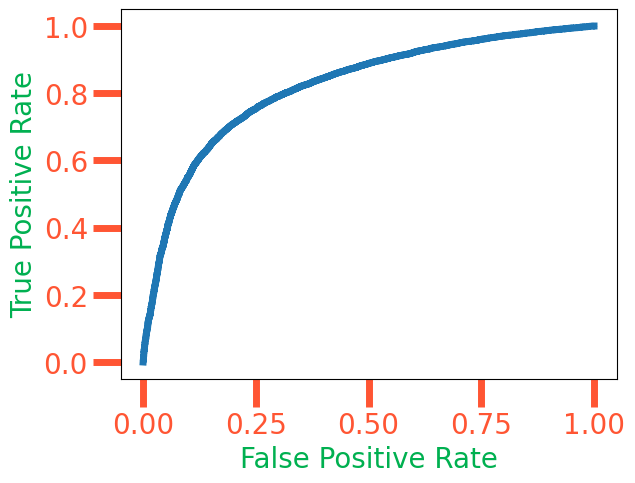

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.8200754570366537

In [ ]:
np.mean(y_test == catboost.predict(X_test))

0.753398836976138

In [ ]:
test_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,day,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g,curs
0,63,292487,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,2.750000,17,3.166667,...,22,5,14,57,1,2023-06-20 14:57:20.000,32.0,254.0,102.0,90.1757
1,63,292489,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,4.178571,19,3.166667,...,22,5,14,57,1,2023-06-03 12:55:48.000,49.0,254.0,95.0,90.1757
2,63,425438,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,7.571429,24,3.166667,...,22,5,14,57,1,2023-06-19 14:57:28.000,33.0,254.0,98.0,90.1757
3,63,514225,2023-07-22 14:57:43.000,0.0,7.0,7.0,0.00,2.821429,19,3.166667,...,22,5,14,57,1,2023-07-01 15:00:07.000,20.0,254.0,33.0,90.1757
4,63,425891,2023-07-22 14:57:43.000,0.0,2.0,1.0,0.50,5.000000,16,3.166667,...,22,5,14,57,1,2023-06-04 12:58:22.000,48.0,254.0,55.0,90.1757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,266,463578,2023-08-04 17:01:44.807,0.0,1.0,-1.0,2.00,1.464286,15,1.571429,...,4,4,17,1,0,2023-06-15 15:42:05.140,2.0,108.0,60.0,90.1757
40767,541,443131,2023-08-04 17:06:18.010,0.0,4.0,3.0,0.25,1.071429,14,1.875000,...,4,4,17,6,0,2023-07-02 16:28:28.227,33.0,190.0,4.0,90.1757
40768,864,425848,2023-08-04 17:07:35.437,0.0,2.0,1.0,0.50,6.250000,19,6.142857,...,4,4,17,7,0,2023-06-15 15:42:05.140,2.0,110.0,130.0,90.1757
40769,864,419254,2023-08-04 17:08:12.690,0.0,4.0,3.0,0.25,2.500000,27,1.000000,...,4,4,17,8,0,2023-06-28 16:14:09.193,37.0,110.0,53.0,90.1757


In [ ]:
test_df["CalculatedProbability"] = catboost.predict_proba(test_df.drop(columns = ["IsCorrect","ValidationDateTime","date_first_info"]))[:,1]

In [ ]:
test_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,week_day,hour,minute,weekend,date_first_info,spros,num_of_g,sgop_with_this_g,curs,CalculatedProbability
0,63,292487,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,2.750000,17,3.166667,...,5,14,57,1,2023-06-20 14:57:20.000,32.0,254.0,102.0,90.1757,0.797326
1,63,292489,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,4.178571,19,3.166667,...,5,14,57,1,2023-06-03 12:55:48.000,49.0,254.0,95.0,90.1757,0.819778
2,63,425438,2023-07-22 14:57:43.000,0.0,4.0,3.0,0.25,7.571429,24,3.166667,...,5,14,57,1,2023-06-19 14:57:28.000,33.0,254.0,98.0,90.1757,0.815533
3,63,514225,2023-07-22 14:57:43.000,0.0,7.0,7.0,0.00,2.821429,19,3.166667,...,5,14,57,1,2023-07-01 15:00:07.000,20.0,254.0,33.0,90.1757,0.891698
4,63,425891,2023-07-22 14:57:43.000,0.0,2.0,1.0,0.50,5.000000,16,3.166667,...,5,14,57,1,2023-06-04 12:58:22.000,48.0,254.0,55.0,90.1757,0.893536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,266,463578,2023-08-04 17:01:44.807,0.0,1.0,-1.0,2.00,1.464286,15,1.571429,...,4,17,1,0,2023-06-15 15:42:05.140,2.0,108.0,60.0,90.1757,0.195254
40767,541,443131,2023-08-04 17:06:18.010,0.0,4.0,3.0,0.25,1.071429,14,1.875000,...,4,17,6,0,2023-07-02 16:28:28.227,33.0,190.0,4.0,90.1757,0.263662
40768,864,425848,2023-08-04 17:07:35.437,0.0,2.0,1.0,0.50,6.250000,19,6.142857,...,4,17,7,0,2023-06-15 15:42:05.140,2.0,110.0,130.0,90.1757,0.829928
40769,864,419254,2023-08-04 17:08:12.690,0.0,4.0,3.0,0.25,2.500000,27,1.000000,...,4,17,8,0,2023-06-28 16:14:09.193,37.0,110.0,53.0,90.1757,0.907512


In [ ]:
test_df[["LocationId","ProductId","ValidationDateTime","CalculatedProbability"]].to_csv("Команда2_Направление1.csv",sep = ";")

## Улучшение модели

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = {'learning_rate': [0.1,0.5,0.01,0.02,0.03,0.04],
        'depth':[3,4,5,6,7,8,9, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100,200,300,500]}
catboost = CatBoostClassifier()
grid_search_result = catboost.grid_search(grid, X=X, y=y, plot=True)

In [ ]:
catboost.best_score_

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
from sklearn.metrics import auc

auc(fpr, tpr)

In [ ]:
train.to_csv("train.csv",index = False)
test.to_csv("test.csv",index = False)


In [ ]:
np.mean(y_test == catboost.predict(X_test))